### Household Data

In [28]:
import pandas as pd
import tarfile
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Read data from Github and return as DataFrame using pandas library

def housing_data():
    tarball_path = Path("datasets/housing.tgz") 
    if not tarball_path.is_file():                                  # check the above file (housing.tgz) in current directory
        Path("datasets").mkdir(parents=True, exist_ok=True)         # create datasets directory in current directory
        url = "https://github.com/ageron/data/raw/main/housing.tgz" 
        urllib.request.urlretrieve(url, tarball_path)               # pull data from remote directory and save in datsets directory
        with tarfile.open(tarball_path, 'r:gz') as housing_tarball:
            housing_tarball.extractall(path = "datasets", filter="data")   # extract data from .tgz file 
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [60]:
# Save figures in local directory

IMAGE_PATH = Path() / "images"
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

def save_image(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
housing = housing_data()

In [9]:
housing.head() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
housing['ocean_proximity'].value_counts() # checking value counts for ocean_proxity attribute because it's contain duplicate value and datatype is object

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [14]:
housing.describe() # display summary for all numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


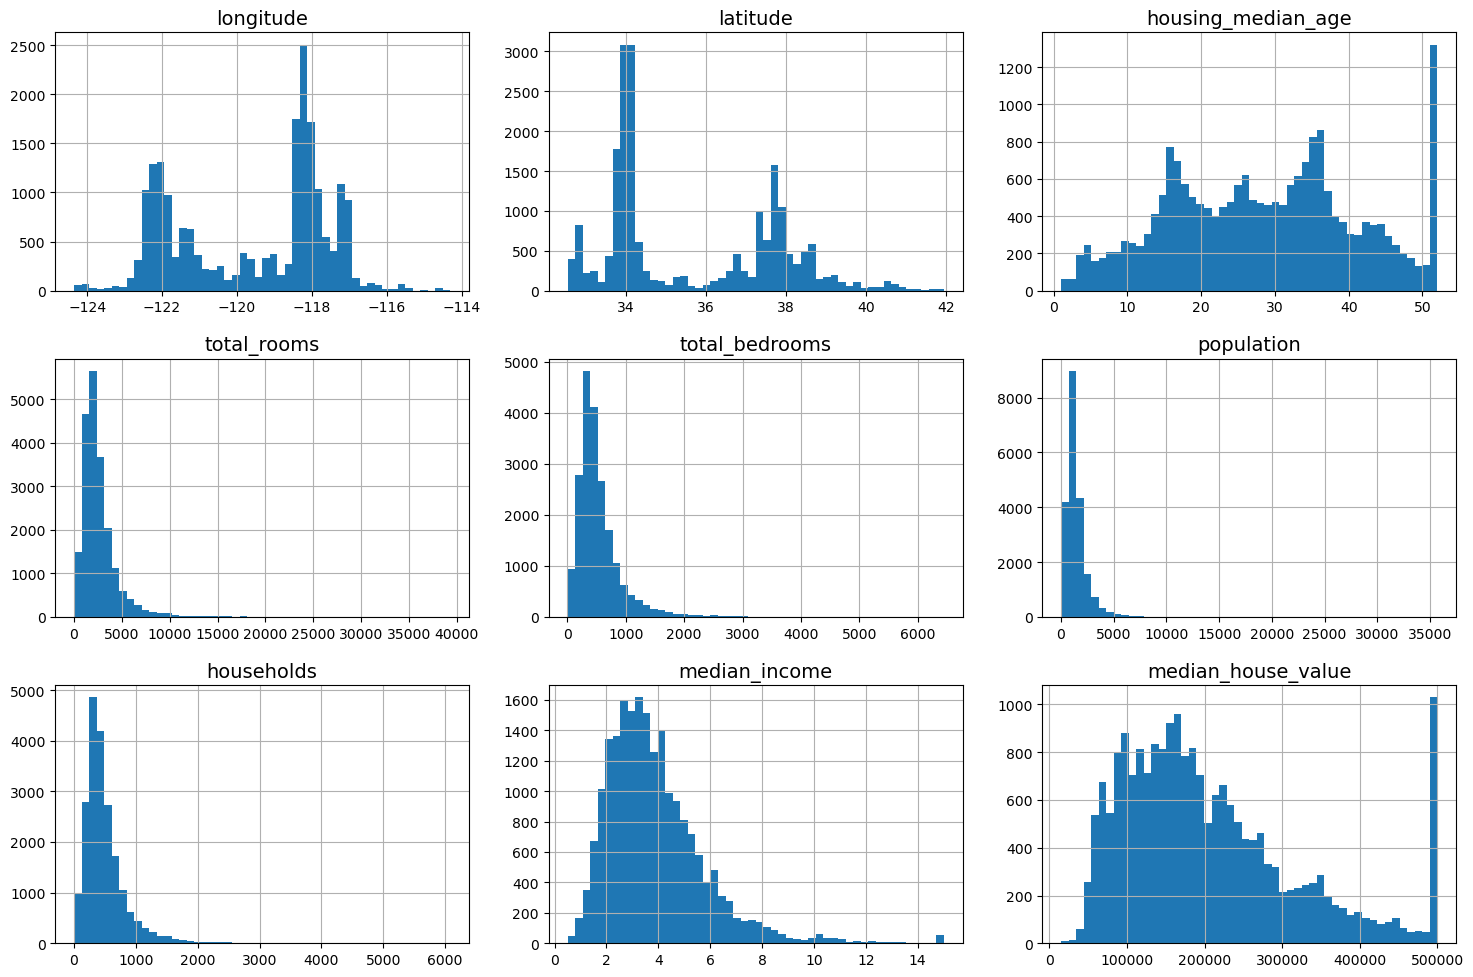

In [62]:
housing.hist(bins=50, figsize=(15, 10)) #histogram plot for all numerical attributes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
save_image("all_numerical_attributes_hist_plot")

In [26]:
# Create a new function to extract train and test data from dataset

def split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_data_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_data_set_size]
    train_indices = shuffled_indices[test_data_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [29]:
train_set, test_set = split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

#### Well above method split data into 80% train set and 20% train set but have couple of issues like it will took inconsistent random data in each run which we want to avoid so creating another approach for split dataset

In [31]:
from zlib import crc32

In [32]:
def is_instance_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

In [33]:
def split_data_with_instance_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:is_instance_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [39]:
housing_with_id = housing.reset_index() #adding an index column because we need id/index in above method
train_set, test_set = split_data_with_instance_id_hash(housing_with_id, 0.2, "index")
housing_with_id.head() # added an new index column

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### we have to make sure new data aaded at the end of dataset or no row ever gets deleted
#### So we can make uniquie identifier with combination of latitude and longitude

In [40]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_data_with_instance_id_hash(housing_with_id, 0.2, "id")

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) #this sci-kit learn method will provide simliar output like split_data

In [57]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf])

Text(0, 0.5, 'No. of districts')

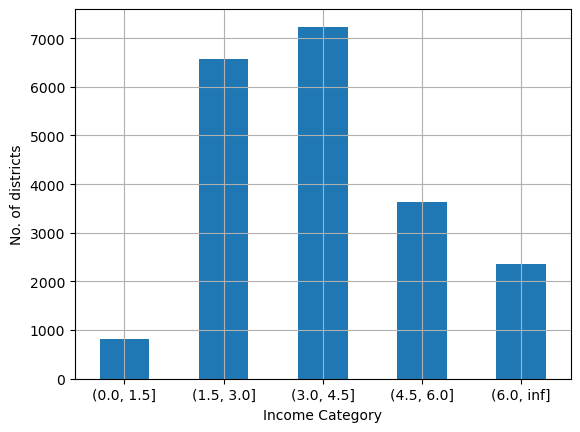

In [58]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("No. of districts")

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    train_set_n = housing.iloc[train_index]
    test_set_n = housing.iloc[test_index]
    strat_splits.append([train_set_n, test_set_n])

In [66]:
# first split
strat_train_set, strat_test_set = strat_splits[0]


In [67]:
# also we can retirieve single split with help of scikit-learn
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [68]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
(3.0, 4.5]    0.350594
(1.5, 3.0]    0.318859
(4.5, 6.0]    0.176296
(6.0, inf]    0.114462
(0.0, 1.5]    0.039789
Name: count, dtype: float64

In [70]:
# Compare income_cat proportions in overall dataset

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall (%)": income_cat_proportions(housing),
    "Stratified (%)": income_cat_proportions(strat_test_set),
    "Random (%)": income_cat_proportions(test_set)
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Stratified Error (%)"] = (compare_props["Stratified (%)"] / compare_props["Overall (%)"] - 1)
compare_props["Random Error (%)"] = (compare_props["Random (%)"] / compare_props["Overall (%)"] - 1)
(compare_props * 100).round(2)

,Overall (%),Stratified (%),Random (%),Stratified Error (%),Random Error (%)
Income Category,,,,,
"(0.0, 1.5]",3.98,4.00,4.24,0.36,6.45
"(1.5, 3.0]",31.88,31.88,30.74,-0.02,-3.59
"(3.0, 4.5]",35.06,35.05,34.52,-0.01,-1.53
"(4.5, 6.0]",17.63,17.64,18.41,0.03,4.42
"(6.0, inf]",11.44,11.43,12.09,-0.08,5.63
